# Tutoriel pour faire une régression linéaire

## Problématique étudiée

Le dataset California Housing sera utilisé pour estimer le prix d'un bien à partir des paramètres d'entrée donnés dans le dataset.

Ce notebook va vous guider sur la méthode de la régression linéaire. Son fonctionnement permet de constituer une ligne de tendance calquée sur les données ou informations préalablement recueillies. En effet, la régression linéaire va fournir une relation visualisable dans un graphique en vue de réaliser des prédictions sur les données

## Code

### Importation des différentes librairies 

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.linear_model as slm
from sklearn.model_selection import train_test_split
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import fetch_california_housing

### Importation du dataset 

La première étape est d'importer le dataset et de voir de quoi il est constitué. Ici on importe le dataset california_housing.

In [3]:
# Import the California Housing dataset
california_housing = fetch_california_housing(as_frame=True)

In [4]:
# Dataset description
print(california_housing.DESCR)

.. _california_housing_dataset:

California Housing dataset
--------------------------

**Data Set Characteristics:**

    :Number of Instances: 20640

    :Number of Attributes: 8 numeric, predictive attributes and the target

    :Attribute Information:
        - MedInc        median income in block group
        - HouseAge      median house age in block group
        - AveRooms      average number of rooms per household
        - AveBedrms     average number of bedrooms per household
        - Population    block group population
        - AveOccup      average number of household members
        - Latitude      block group latitude
        - Longitude     block group longitude

    :Missing Attribute Values: None

This dataset was obtained from the StatLib repository.
https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.html

The target variable is the median house value for California districts,
expressed in hundreds of thousands of dollars ($100,000).

This dataset was derived

Cette description nous montre 20640 entrées sur un groupe de 8 prédictions. On y retrouve le médian des revenus et des âges, la moyenne de chambre ou de salle de bain dans un foyer.

Chaque bloc de groupe d'une population contient 600 à 3000 personnes. Et pour chacune de ces groupes résidant dans un même foyer, nous avons un jeu de données sur la moyenne des pièces et chambres. Ces données resortent principalement des maisons peu habitées, vides comme des résidences de vacances.


In [5]:
# Aperçu des données
california_housing.frame.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


### Phase d'apprentissage du modèle

Pour chacune des lignes, cela réprésente un district en Californie.

Nous avons 3 types d'informations. Le premier est lié à la démographie (revenus, population, maison occupée), le deuxième à la location (longitude, latitude) et le dernier plus générale lié à une maison (nombre de pièces et chambres, l'âge des résidents). Chaque colonne correspond à une moyenne ou un médian.

In [6]:
# target of house value
california_housing.target.head()

0    4.526
1    3.585
2    3.521
3    3.413
4    3.422
Name: MedHouseVal, dtype: float64

Cette cible contient le médian de la valeur d'une maison pour chaque district. Par conséquent, nous avons un problème de régression.

In [7]:
california_housing.frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   MedInc       20640 non-null  float64
 1   HouseAge     20640 non-null  float64
 2   AveRooms     20640 non-null  float64
 3   AveBedrms    20640 non-null  float64
 4   Population   20640 non-null  float64
 5   AveOccup     20640 non-null  float64
 6   Latitude     20640 non-null  float64
 7   Longitude    20640 non-null  float64
 8   MedHouseVal  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


Nous allons vérifier les données: 
 - il y a 20640 échantillons et 9 colonnes.
 - toutes les colonnes sont des nombres flottants
 - aucune n'est vide
 

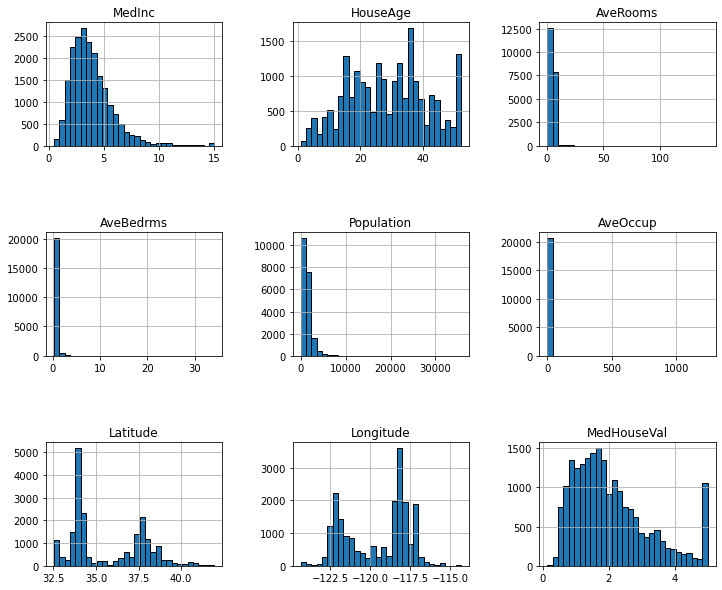

In [8]:
# Let’s have a quick look at the distribution of these features by plotting their histograms
california_housing.frame.hist(figsize=(12, 10), bins=30, edgecolor="black")
plt.subplots_adjust(hspace=0.7, wspace=0.4)

Nous regardons quelques résultats de prédiction.

La plupart des graphiques sont plus ou moins uniformes. Nous remarquons cependant que les graphiques des chambres, salles de bains, populations et des occupations ont sûrement des données aberrantes. En effet, nous pouvons voir que sur la majeure partie de l'axe des absices, le modèle est vide.

Nous allons vérifier les données de ces 4 graphiques.

In [9]:
features_of_interest = ["AveRooms", "AveBedrms", "AveOccup", "Population"]
california_housing.frame[features_of_interest].describe()

,AveRooms,AveBedrms,AveOccup,Population
count,20640.000000,20640.000000,20640.000000,20640.000000
mean,5.429000,1.096675,3.070655,1425.476744
std,2.474173,0.473911,10.386050,1132.462122
min,0.846154,0.333333,0.692308,3.000000
25%,4.440716,1.006079,2.429741,787.000000
50%,5.229129,1.048780,2.818116,1166.000000
75%,6.052381,1.099526,3.282261,1725.000000
max,141.909091,34.066667,1243.333333,35682.000000


Nous le voyons bien sur le tableau ci-dessus que la différence sur le max et les 75% est assez immense. Cela confirme nos données aberrantes.

Text(0.5, 1.0, 'Housing Prices Pairplot')

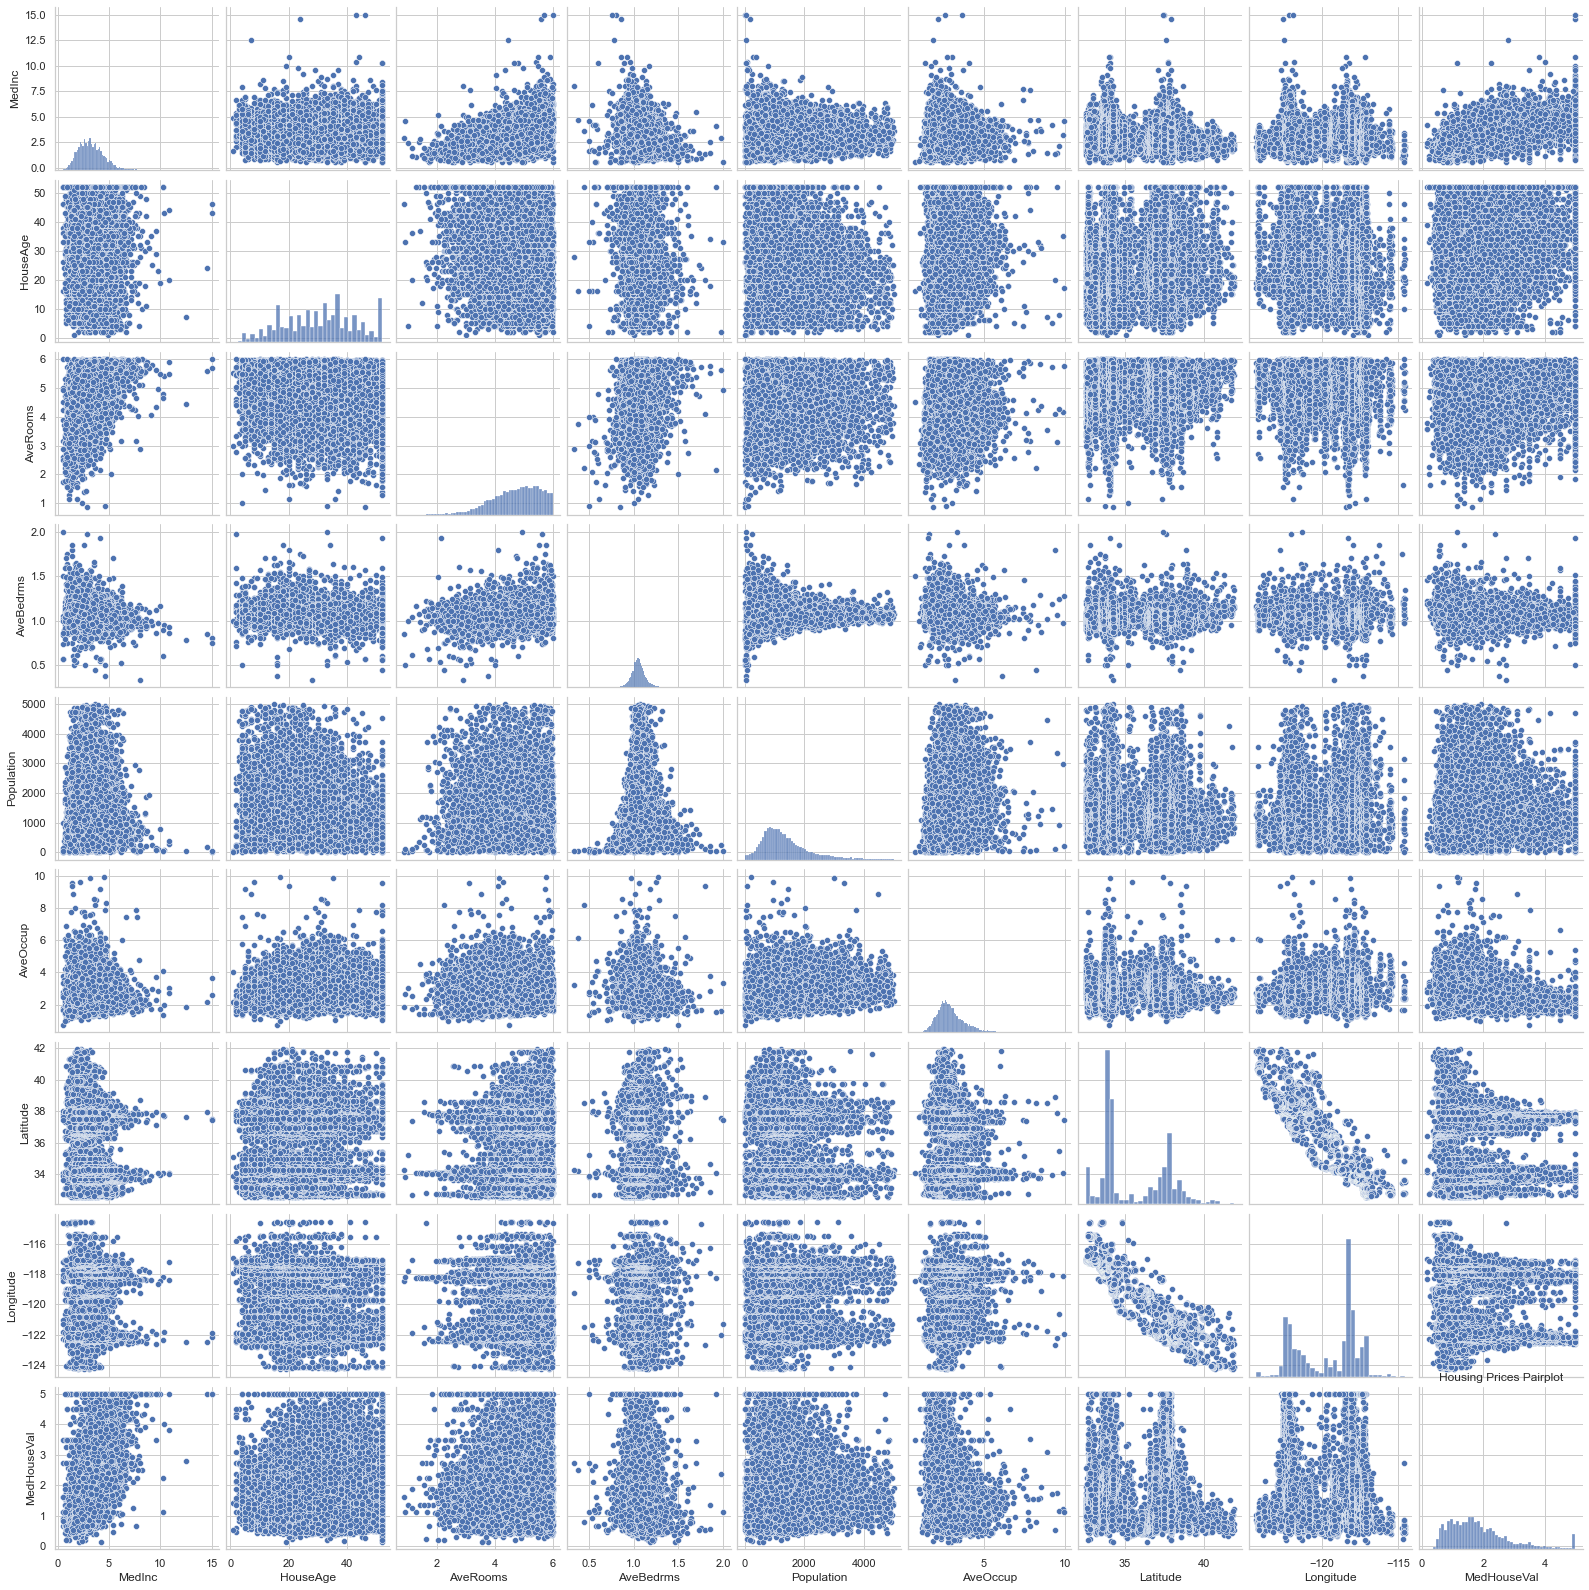

In [22]:
data_refine = california_housing.frame
data_refine = data_refine[data_refine['AveRooms'] <= 6]
data_refine = data_refine[data_refine['AveBedrms'] <= 2]
data_refine = data_refine[data_refine['AveOccup'] <= 10]
data_refine = data_refine[data_refine['Population'] <= 5000]

sns.pairplot(data_refine)
plt.title("Housing Prices Pairplot")

J'ai tracé plusieurs distributions bivariées par paires avec le dataset filtré.

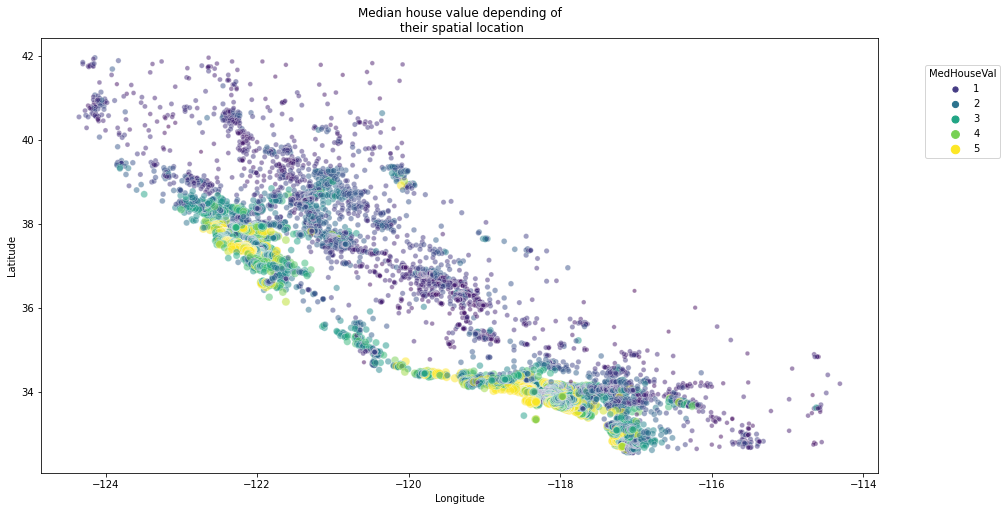

In [11]:
plt.figure(figsize=(15,8))
sns.scatterplot(data=california_housing.frame, x="Longitude", y="Latitude",
                size="MedHouseVal", hue="MedHouseVal",
                palette="viridis", alpha=0.5)
plt.legend(title="MedHouseVal", bbox_to_anchor=(1.05, 0.95),
           loc="upper left")
_ = plt.title("Median house value depending of\n their spatial location")

Le nuage de point représente la valeur du prix des maisons dans leurs locations géographiques.

On constate que les maisons les plus chères se trouvent sur les côtes, où les grandes villes de Californie sont situées: San Diego, Los Angeles, San Jose ou San Francisco.


Nous allons maintenant entrainer nos jeux de données pour prédire la valeur d'une maison:
 - pour les train set (données à entainer), nous prenons le jeu de données complet et nous enlevons la colonne MedHouseVal (ce sont des données de tests)
 - pour les tests, nous prenons la colonne MedHouseVal (20% des données)

In [12]:
data_refine = california_housing.frame.dropna(axis = 0)

X = data_refine.drop('MedHouseVal', axis = 1)
y = data_refine['MedHouseVal']

LR = slm.LinearRegression()
X_train,X_test,Y_train,Y_test = train_test_split(X,y,test_size=0.2)
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

LR.fit(X_train, Y_train)
print(LR.score (X_test, Y_test))

(16512, 8)
(16512,)
(4128, 8)
(4128,)
0.580526023587855


L’association est assez forte puisque le coefficient de corrélation vaut environ 0,6.


Predicted Value : 1.1301950071802125
Actual Value : 0.809


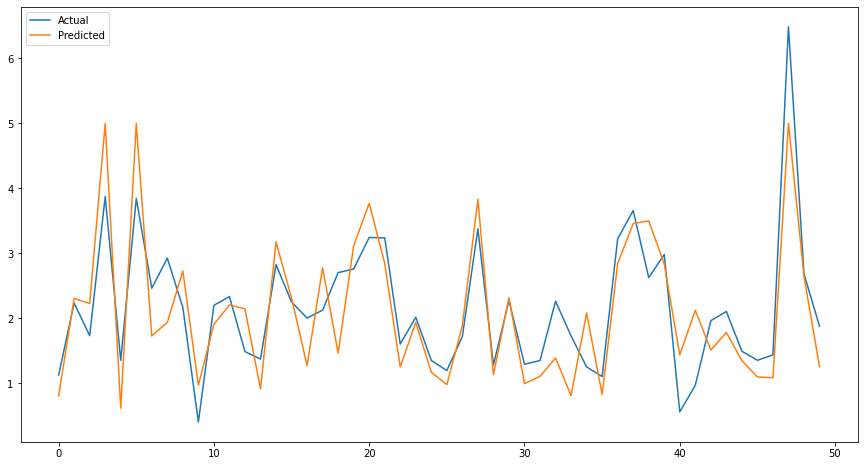

In [13]:
predict = LR.predict(X_test)

gr = pd.DataFrame({'Predicted':predict,'Actual':Y_test})
gr = gr.reset_index()
gr = gr.drop(['index'],axis=1)

plt.figure(figsize=(15,8))
plt.plot(gr[:50])
plt.legend(['Actual','Predicted'])
print('Predicted Value :',predict[0])
print('Actual Value :',Y_test.values[0])

Les tests sont faits sur 50 entrées. Nous pouvons remarquer sur le graphique ci-dessus que la prédiction est corrélée avec les prix actuels des maisons.

Pour finaliser, nous avons entré une régression linéaire sur le prix des maisons en fonction des pièces.

#### Ceci conclut notre tutoriel, et sentez-vous libre de jouer avec les paramètres du modèle pour mieux le comprendre !